# Advanced Machine Learning for Physics 2021-2022
## Hands-on session 2
### Open on ASM: [![Open In Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/GiakDonini/corso_AML_2022/notebooks/es3/My_version.ipynb/blob/master/path/to/notebook.ipynb)

Implementation in pytorch of a CNN+MLP for the self-supervised contrastive learning with SimCLR task of leranign useful representations of QCD hadronic jets from single quark/gluons and merged jest from boosted decays of W bosons.

At the extreme energies of the Large Hadron Collider, massive particles can be produced with such high Lorentz boost that their decays into hadrons (hadron jets) are collimated in such a way that the resulting particles overlap. Deducing whether the substructure of an observed jet is due to a single low-mass particle or to multiple decay objects of a high-mass particle is an important problem in LHC data analysis. Traditional approaches are based on high-level observables built from theoretical models of energy deposition in calorimeters, but the complexity of the data makes this task an excellent candidate for the application of deep learning tools. The data collected by the detector can in fact be represented as a two-dimensional image, lending itself to the natural application of image classification techniques.

A description of the dataset and classification results obtained with standard supervised techniques are available [here](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.93.094034).

A reduced size dataset is available in the github folder:
[dataset](https://github.com/stefanogiagu/corso_AML_2022/tree/main/notebooks/es3). 

Based on a modified version of several examples available in the web and on the original paper: 

[T.Chen, S.Kornblith,M.Norouzi, and G.Hinton: A simple framework for contrastive learning of visual representations](https://arxiv.org/abs/2002.05709).


How it works:
- during each training iteration, for each image of the mini batch two new versions are created by applying data augmentation techniques like cropping, flips, rotations, gaussian noise, blurring, etc.
- on these images a CNN is applied to obtain as output a 1D feature vector on which a small MLP (Projection Head) is applied to produce a vector representation *z*
- the output representations of the two augmented images are then trained to be close to each other, while all other images in that batch should be as different as possible (by minimising a specific loss (contrastive loss))

The genera network architecture is represented in the following schema:

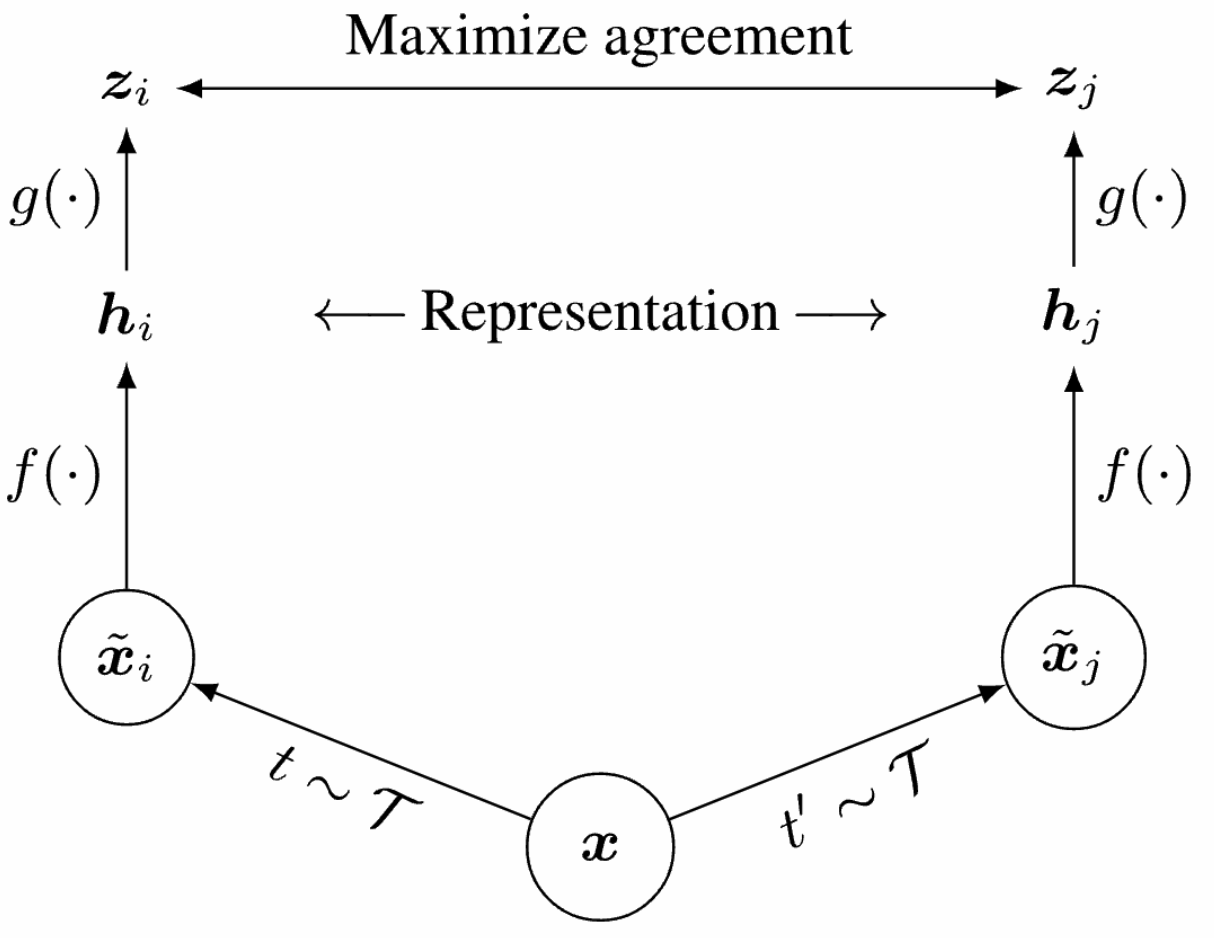

in which xi and xj are the two augmented version of x, f is the encoder BasModel, a CNN, which take in input x and produce the latent representation h, and g is a MLP (Projection Head) that starting from h produce the vector representation z in which we apply the contrastive loss.

The contrastive lossused by SimCLR is the popular Noise Contrastive Estimator (NCE) loss:

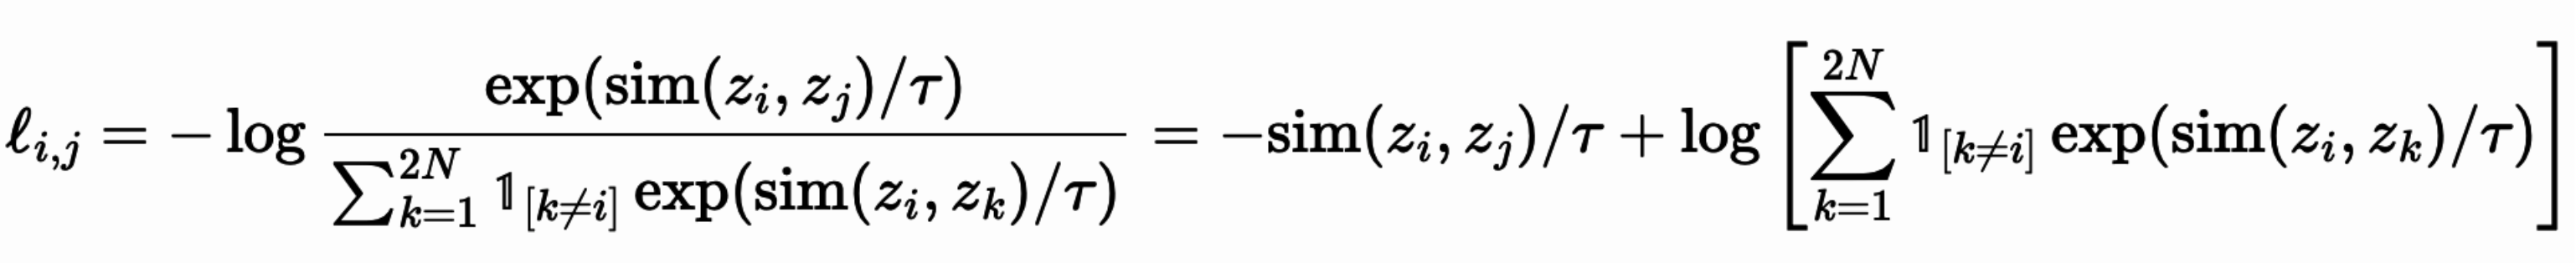

a modified form of the cross entropy loss ([A.V.D.Oord, Y.Li, and O.Vinyals: Representation learning with contrastive predictive coding, arXiv:1807.03748 (2018)](https://arxiv.org/abs/1807.03748)) , in which (zi,zj) is a positive pair, (zi,zk) a negative pair. The function sim si the similarity metric, the cosine similarity in the case of simCLR.

Stefano Giagu - v1.0 - 15.3.2022

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Read dataset and preporcess it**

(20000, 32, 32)
(20000,)


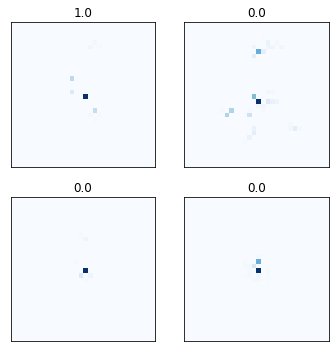

In [ ]:
# jet images, 32x32 pixels (eta, phi) plane, with energy deposit on each calorimetric cell
# targets: binary label 0, 1, nornmal and merged jet

import numpy as np

f = np.load('simCLR_dataset.npz')
train_features = f['train_features']
train_targets = f['train_targets']

print(train_features.shape)
print(train_targets.shape)

import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
for i in range(4):
  ax = plt.subplot(2, 2, i+1)
  ax.imshow(train_features[i], cmap='Blues')
  ax.set_title(train_targets[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.tight_layout()

# Nuova sezione

In [ ]:
# some useful libs
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

1.10.0+cu111
0.11.1+cu111


In [ ]:
# define device to use (cpu/gpu)
if torch.cuda.is_available():
  print('# of GPUs available: ', torch.cuda.device_count())
  print('First GPU type: ',torch.cuda.get_device_name(0))
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

# of GPUs available:  1
First GPU type:  Tesla K80
Computation device: cuda



In [ ]:
# preprocess data: split on training, validation, test
# normalize features (pixels) in [0,1]

from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler()

# training, validation, test split
from sklearn.model_selection import train_test_split
testset_frac = 0.2 # test set fraction wrt whole samples
valiset_frac = 0.25 # validation set fraction wrt training+validation
X_train,X_test,Y_train,Y_test = train_test_split(train_features,train_targets,test_size=testset_frac, shuffle=True, random_state=1234)
X_train,X_vali,Y_train,Y_vali = train_test_split(X_train,Y_train,test_size=valiset_frac, shuffle=True, random_state=1234)

#li metto in riga ("flat vector") per normalizzarli
X_train = X_train.reshape(X_train.shape[0],32*32)
X_vali = X_vali.reshape(X_vali.shape[0],32*32)
X_test = X_test.reshape(X_test.shape[0],32*32)

scaler.fit(X_train) #i parametri della rinormalizzazione vanno presi solo dal fit_set per evitare leaking
X_train = scaler.transform(X_train)
X_vali = scaler.transform(X_vali)
X_test = scaler.transform(X_test)

#reshape everything in the original format
X_train = X_train.reshape(X_train.shape[0],32,32)
X_vali = X_vali.reshape(X_vali.shape[0],32,32)
X_test = X_test.reshape(X_test.shape[0],32,32)
print('X_train shape before expanding: ',X_train.shape)
#we add a dummy channel (for the lable maybe? ELETTRA)
print("prima di expand:",X_train[3][16][16])
X_train = np.expand_dims(X_train, -1) #the -1 indicates that the new dimension position is the last
print("dopo expand:",X_train[3][16][16])
X_vali = np.expand_dims(X_vali, -1)
X_test = np.expand_dims(X_test, -1)

print('X_train shape: ',X_train.shape)
print('Y_train shape: ',Y_train.shape)
print('X_vali shape: ',X_vali.shape)
print('Y_vali shape: ',Y_vali.shape)
print('X_test shape: ',X_test.shape)
print('Y_test shape: ',Y_test.shape)

X_train shape before expanding:  (12000, 32, 32)
prima di expand: 0.029441612
dopo expand: [0.02944161]
X_train shape:  (12000, 32, 32, 1)
Y_train shape:  (12000,)
X_vali shape:  (4000, 32, 32, 1)
Y_vali shape:  (4000,)
X_test shape:  (4000, 32, 32, 1)
Y_test shape:  (4000,)


In [ ]:
# transform numpy vectors to pytorch tensors
X_train_pt = torch.Tensor(X_train)
Y_train_pt = torch.Tensor(Y_train)
X_vali_pt = torch.Tensor(X_vali)
Y_vali_pt = torch.Tensor(Y_vali)
X_test_pt = torch.Tensor(X_test)
Y_test_pt = torch.Tensor(Y_test)

# switch channel dimension position as needed by pytorch (NOTE: in numpy/keras (dim1,dim2,..., channels) in pytorch (channel, dim1, dim2, ...))
X_train_pt = X_train_pt.permute(0,3,1,2)
X_vali_pt = X_vali_pt.permute(0,3,1,2)
X_test_pt = X_test_pt.permute(0,3,1,2)

print(X_train_pt.shape)
print(Y_train_pt.shape)
print(X_vali_pt.shape)
print(Y_vali_pt.shape)
print(X_test_pt.shape)
print(Y_test_pt.shape)
print("OUR DATASET IS READY!")

torch.Size([12000, 1, 32, 32])
torch.Size([12000])
torch.Size([4000, 1, 32, 32])
torch.Size([4000])
torch.Size([4000, 1, 32, 32])
torch.Size([4000])
OUR DATASET IS READY!


**Let's first try a conventional supervised classification task with a CNN**



In [ ]:
# CNN VGG-like model

from torch import nn
import torch.nn.functional as F

class VGGModel(nn.Module):
  def __init__(self):
    super(VGGModel, self).__init__()
  
    # first block
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3))
    
    # second block
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3,3))

    # third block
    self.conv3 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3,3))
    
    self.flatten = nn.Flatten()

    # MLP
    self.fc1 = nn.Linear(in_features=128, out_features=64)
    self.fc2 = nn.Linear(in_features=64, out_features=64)
    self.fc3 = nn.Linear(in_features=64, out_features=1)

    self.act = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=(2,2))
    self.act2 = nn.Sigmoid()

    self.drop = nn.Dropout(p=0.5)
    
  def forward(self, x):
    out = self.act(self.conv1(x))
    out = self.pool(out)
    out = self.act(self.conv2(out))
    out = self.pool(out)
    out = self.act(self.conv3(out))

    #flatten
    out = self.flatten(out)

    out = self.drop(out)
    out = self.act(self.fc1(out))
    out = self.drop(out)
    out = self.act(self.fc2(out))
    out = self.act2(self.fc3(out))
    
    return out

In [ ]:
model = VGGModel()
print(model)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(1,32,32))
else:
  summary(model, input_size=(1,32,32))

VGGModel(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (act): ReLU()
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (act2): Sigmoid()
  (drop): Dropout(p=0.5, inplace=False)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 30, 30]              80
              ReLU-2            [-1, 8, 30, 30]               0
         MaxPool2d-3            [-1, 8, 15, 15]               0
            Conv2d-4            [-1, 8, 13, 13]             584
              ReLU-5         

In [ ]:
#loss 
loss_func = nn.BCELoss() #binary cross entropy loss

#metric accuracy
#dunque la metrica coincide con l'accuracy, giusto? ELETTRA
def accuracy(out, yb):
    preds = out.cpu().reshape(-1).detach().numpy().round()
    return (preds == yb.cpu().detach().numpy()).mean()

metric_func = accuracy

# optim
from torch import optim
opt = optim.Adam(model.parameters(), lr=1e-3)

# scheduler for step decay lr schedule
#scheduler = optim.lr_scheduler.StepLR(opt, 10, gamma=0.1, last_epoch=-1, verbose=True)

In [ ]:
# move the model into the GPU
model.to('cpu')
print('The model is in the: ', next(model.parameters()).device)
model.to(device)
print('now the model is in the: ', next(model.parameters()).device)

The model is in the:  cpu
now the model is in the:  cuda:0


In [ ]:
#Checkpoints (to save model parameters during training)
class SaveBestModel:
    def __init__(self, best_valid_loss=float('inf')): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion, metric,
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            # method to save a model (the state_dict: a python dictionary object that 
            # maps each layer to its parameter tensor) and other useful parametrers
            # see: https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                'metric': metric,
                }, 'best_model.pth')

In [ ]:
# training parameters

epochs = 200
batch_size = 64

# define dataloaders
from torch.utils.data import TensorDataset, DataLoader

dataset_train = TensorDataset(X_train_pt, Y_train_pt) 
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True) 

dataset_vali = TensorDataset(X_vali_pt, Y_vali_pt) 
dataloader_vali = DataLoader(dataset_vali, batch_size=batch_size*4) 

In [ ]:
#training loop

import time

save_best_model = SaveBestModel()

# lists to save loss and metric history
hist_loss = []
hist_metric = []
hist_vloss = []
hist_vmetric = []

#loop over epochs
for epoch in range(epochs):
    t0 = time.time()

    #training step
    model.train()

    train_loss = 0.0
    train_metric = 0.0
    counter = 0
    for xb, yb in dataloader_train: #takes a batch from the train dataloader 
        counter += 1 
        xb=xb.type(torch.float).to(device) #move troch tensors to device (cpu or GPU)
        yb=yb.type(torch.float).to(device)
        
        pred = model(xb) #get prediction for batch
        loss = loss_func(pred, torch.unsqueeze(yb,1)) #compute loss
        metric = metric_func(pred, yb) #compute metric

        train_loss += loss.item() #update total loss
        train_metric += metric.item() #update total metric

        # backpropagation
        loss.backward()
        # update weights
        opt.step()
        # set to zero gradients for the next step
        opt.zero_grad()
 
    # normalize loss and metric by number of batches
    train_loss = train_loss/counter
    train_metric = train_metric/counter

    # update history
    hist_loss.append(train_loss)
    hist_metric.append(train_metric)


    # evaluation setp (same as trainign but w/o backpropagation)
    model.eval()

    vali_loss = 0.0
    vali_metric = 0.0
    counter = 0
    with torch.no_grad():
      for xb, yb in dataloader_vali:
        counter += 1
        xb=xb.type(torch.float).to(device)
        yb=yb.type(torch.float).to(device)
        pred = model(xb)
        vloss = loss_func(pred, torch.unsqueeze(yb,1))
        vmetric = metric_func(pred, yb)
        vali_loss += vloss.item()
        vali_metric += vmetric.item()
        
    vali_loss = vali_loss/counter
    vali_metric = vali_metric/counter    

    hist_vloss.append(vali_loss)
    hist_vmetric.append(vali_metric)

    #save best model
    save_best_model(vali_loss, epoch, model, opt, loss_func, metric_func)   

    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.4f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f" % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric))

    # update learning rate schedule
    #scheduler.step()


Best validation loss: 0.5184503644704819

Saving best model for epoch: 1

epoch: 1, time(s): 1.2844, train loss: 0.662649, train metric: 0.592836, vali loss: 0.518450, vali metric: 0.762061

Best validation loss: 0.4242842085659504

Saving best model for epoch: 2

epoch: 2, time(s): 1.1897, train loss: 0.504223, train metric: 0.778923, vali loss: 0.424284, vali metric: 0.818896

Best validation loss: 0.40212515369057655

Saving best model for epoch: 3

epoch: 3, time(s): 1.1842, train loss: 0.463083, train metric: 0.799368, vali loss: 0.402125, vali metric: 0.833105

Best validation loss: 0.39115965738892555

Saving best model for epoch: 4

epoch: 4, time(s): 1.1737, train loss: 0.439740, train metric: 0.811336, vali loss: 0.391160, vali metric: 0.839160

Best validation loss: 0.3842652477324009

Saving best model for epoch: 5

epoch: 5, time(s): 1.1652, train loss: 0.428695, train metric: 0.816323, vali loss: 0.384265, vali metric: 0.839111

Best validation loss: 0.3802272230386734



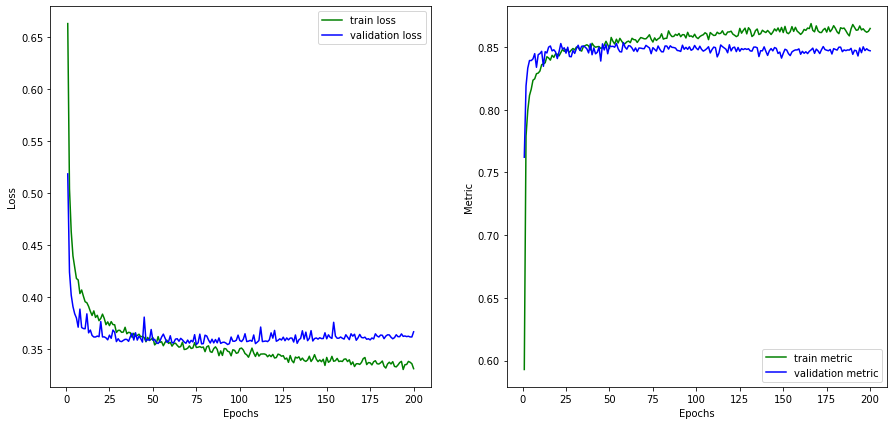

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(1,2,1)
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_vloss)+1), hist_vloss, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1,len(hist_metric)+1), hist_metric,  color='green', linestyle='-', label='train metric')
plt.plot(range(1,len(hist_vmetric)+1),hist_vmetric, color='blue', linestyle='-', label='validation metric')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()

# SimCLR

First part delas with the dataset creation and data augmentation. We'll do that by creating a torch Dataset custom class and a custom transformation function that will apply a torch transofrmation set to the input image and produce in output two augmented version of each image.

In [ ]:
import torchvision
from torchvision import transforms, utils

# custom class that takes an image and outputs n_views random ransformation according to the 
# base_transforms list 
class ContrastiveTransformations(object):
    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

#nota:chiameremo transform=ContrastiveTransformations( base_transforms=contrast_transforms, n_views=2))

In [ ]:
# Data-augmentation transformations
# compose 4 different transformations from the trochvision lib: random horizontal pixels flip, random vertical pixels flip, random rotation, and random crop of the image

contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.RandomRotation(180.),
                                          transforms.RandomResizedCrop(size=32),
                                         ])

In [ ]:
from operator import indexOf
# create a custom dataset
from torch.utils.data import Dataset, DataLoader

class JetSubStructure(Dataset):
    """JetSubstructure dataset."""

    def __init__(self, data, labels, phase='train', transform=None):
        """
        Args:
            data: torch tensor containing images
            labels: torch tensor containing associated label
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.phase = phase
        self.data = data
        self.label = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

#the following is called (as you can check with the print) when we write this:
#images, label = dataset_img[i]
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.data[idx]
        label = self.label[idx]

        if self.transform:
          if self.phase == 'train':
            sample = self.transform(sample)
          else: 
            sample = [sample, sample]

        #print("hello helloooo!")
        return sample, label

In [ ]:
# create the dataset
dataset_img = JetSubStructure(data=X_train_pt, labels=Y_train_pt, phase='train', transform=ContrastiveTransformations( base_transforms=contrast_transforms, n_views=2))
dataset_img_v = JetSubStructure(data=X_vali_pt, labels=Y_vali_pt, phase='vali', transform=ContrastiveTransformations( base_transforms=contrast_transforms, n_views=2))

In [ ]:
# print one element of the dataset
for i in range(len(dataset_img)):
  images, label = dataset_img[i]
  print(images[0].shape, images[1].shape) #note: we expect 2 images cause n_views=2
  print("shape:",label.shape)
  break

torch.Size([1, 32, 32]) torch.Size([1, 32, 32])
shape: torch.Size([])


In [ ]:
# create the dataloaders (make sure to drop images that do not cope with the batch_size=128 requirement)
batch_size = 128
dataloader_img = DataLoader(dataset_img, batch_size=batch_size, shuffle=True, drop_last=True) 
dataloader_img_v = DataLoader(dataset_img_v, batch_size=batch_size, shuffle=True, drop_last=True)
#drop_last=True to avoid last iteration, indeed if the dataset_img is not a multiple of 128,
#last batch could be very small!

In [ ]:
# test it
x1,x2 = next(iter(dataloader_img))
print(x1[0].shape, x1[1].shape, x2.shape )

torch.Size([128, 1, 32, 32]) torch.Size([128, 1, 32, 32]) torch.Size([128])


In [ ]:
# SimCLR Model

# three parts:

# BaseModel: same VGG as in the supervised case but w/o sigmoid output layer
# Projection Head: a simple MLP
# SimCLR: a composition of the two previous blocks

from torch import nn
import torch.nn.functional as F

class VGGBaseModel(nn.Module):
  def __init__(self):
    super(VGGBaseModel, self).__init__()
  
    # first block
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3))
  
    # second block
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3,3))

    # tird block
    self.conv3 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3,3))
    
    self.flatten = nn.Flatten()

    # MLP
    self.fc1 = nn.Linear(in_features=128, out_features=64)
    self.fc2 = nn.Linear(in_features=64, out_features=64)

    self.act = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=(2,2))
    self.act2 = nn.Sigmoid()

    self.drop = nn.Dropout(p=0.5)
    
  def forward(self, x):
    out = self.act(self.conv1(x))
    out = self.pool(out)
    out = self.act(self.conv2(out))
    out = self.pool(out)
    out = self.act(self.conv3(out))  

    #flatten
    out = self.flatten(out)

    out = self.drop(out)
    out = self.act(self.fc1(out))
    out = self.drop(out)
    out = self.act(self.fc2(out))

    return out

In [ ]:
class ProjectionHead(nn.Module):
  def __init__(self,
               in_features,
               hidden_features,
               out_features, **kwargs):
    super(ProjectionHead, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.hidden_features = hidden_features

    self.layers = nn.Sequential(
      nn.Linear(self.in_features, self.hidden_features, bias=True),
      nn.BatchNorm1d(self.hidden_features),
      nn.ReLU(),
      nn.Linear(self.hidden_features, self.out_features, bias=False),
      nn.BatchNorm1d(self.out_features)
    )

  def forward(self,x):
    out = self.layers(x)
    return out

In [ ]:
class SimCLRModel(nn.Module):
  def __init__(self, base_model, proj_head):
    super(SimCLRModel, self).__init__()
    self.base_model = base_model
    self.proj_head = proj_head

  def forward(self,x):
    out = self.base_model(x)
    out = self.proj_head(out) 
    return out

In [ ]:
# instantiate the model
base=VGGBaseModel()
proj=ProjectionHead(64, 2048, 128)
model = SimCLRModel(base, proj)
print(model)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(1,32,32))
else:
  summary(model, input_size=(1,32,32))

  #perchè quando facciamo BatchNorm1d(n_features) abbiamo 2*n_features pesi nuovi? (ELETTRA)

SimCLRModel(
  (base_model): VGGBaseModel(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=128, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=64, bias=True)
    (act): ReLU()
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (act2): Sigmoid()
    (drop): Dropout(p=0.5, inplace=False)
  )
  (proj_head): ProjectionHead(
    (layers): Sequential(
      (0): Linear(in_features=64, out_features=2048, bias=True)
      (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=2048, out_features=128, bias=False)
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
)
----------------

In [ ]:
model = model.to(device)

In [ ]:
# NCELoss function
# from https://github.com/Spijkervet/SimCLR implementation

class NCELoss(nn.Module):
    def __init__(self, batch_size, temperature):
        super(NCELoss, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature

        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        print("maskierella", mask)
        return mask

    def forward(self, z_i, z_j):

        N = 2 * self.batch_size

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)
        
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)
        
        #SIMCLR
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long()
        
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        return loss

In [ ]:
# LARS optmizers (optimizer procedure designed for large mini-batch training)
# Y. You, I. Gitman, and B. Ginsburg. (https://arxiv.org/abs/1708.03888)

# implementation code from https://github.com/Spijkervet/SimCLR

from torch.optim.optimizer import Optimizer, required
import re

EETA_DEFAULT = 0.001


class LARS(Optimizer):
    """
    Layer-wise Adaptive Rate Scaling for large batch training.
    Introduced by "Large Batch Training of Convolutional Networks" by Y. You,
    I. Gitman, and B. Ginsburg. (https://arxiv.org/abs/1708.03888)
    """

    def __init__(
        self,
        params,
        lr=required,
        momentum=0.9,
        use_nesterov=False,
        weight_decay=0.0,
        exclude_from_weight_decay=None,
        exclude_from_layer_adaptation=None,
        classic_momentum=True,
        eeta=EETA_DEFAULT,
    ):
        """Constructs a LARSOptimizer.
        Args:
        lr: A `float` for learning rate.
        momentum: A `float` for momentum.
        use_nesterov: A 'Boolean' for whether to use nesterov momentum.
        weight_decay: A `float` for weight decay.
        exclude_from_weight_decay: A list of `string` for variable screening, if
            any of the string appears in a variable's name, the variable will be
            excluded for computing weight decay. For example, one could specify
            the list like ['batch_normalization', 'bias'] to exclude BN and bias
            from weight decay.
        exclude_from_layer_adaptation: Similar to exclude_from_weight_decay, but
            for layer adaptation. If it is None, it will be defaulted the same as
            exclude_from_weight_decay.
        classic_momentum: A `boolean` for whether to use classic (or popular)
            momentum. The learning rate is applied during momeuntum update in
            classic momentum, but after momentum for popular momentum.
        eeta: A `float` for scaling of learning rate when computing trust ratio.
        name: The name for the scope.
        """

        self.epoch = 0
        defaults = dict(
            lr=lr,
            momentum=momentum,
            use_nesterov=use_nesterov,
            weight_decay=weight_decay,
            exclude_from_weight_decay=exclude_from_weight_decay,
            exclude_from_layer_adaptation=exclude_from_layer_adaptation,
            classic_momentum=classic_momentum,
            eeta=eeta,
        )

        super(LARS, self).__init__(params, defaults)
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.use_nesterov = use_nesterov
        self.classic_momentum = classic_momentum
        self.eeta = eeta
        self.exclude_from_weight_decay = exclude_from_weight_decay
        # exclude_from_layer_adaptation is set to exclude_from_weight_decay if the
        # arg is None.
        if exclude_from_layer_adaptation:
            self.exclude_from_layer_adaptation = exclude_from_layer_adaptation
        else:
            self.exclude_from_layer_adaptation = exclude_from_weight_decay

    def step(self, epoch=None, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        if epoch is None:
            epoch = self.epoch
            self.epoch += 1

        for group in self.param_groups:
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]
            eeta = group["eeta"]
            lr = group["lr"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                param = p.data
                grad = p.grad.data

                param_state = self.state[p]

                # TODO: get param names
                # if self._use_weight_decay(param_name):
                grad += self.weight_decay * param

                if self.classic_momentum:
                    trust_ratio = 1.0

                    # TODO: get param names
                    # if self._do_layer_adaptation(param_name):
                    w_norm = torch.norm(param)
                    g_norm = torch.norm(grad)

                    device = g_norm.get_device()
                    trust_ratio = torch.where(
                        w_norm.gt(0),
                        torch.where(
                            g_norm.gt(0),
                            (self.eeta * w_norm / g_norm),
                            torch.Tensor([1.0]).to(device),
                        ),
                        torch.Tensor([1.0]).to(device),
                    ).item()

                    scaled_lr = lr * trust_ratio
                    if "momentum_buffer" not in param_state:
                        next_v = param_state["momentum_buffer"] = torch.zeros_like(
                            p.data
                        )
                    else:
                        next_v = param_state["momentum_buffer"]

                    next_v.mul_(momentum).add_(scaled_lr, grad)
                    if self.use_nesterov:
                        update = (self.momentum * next_v) + (scaled_lr * grad)
                    else:
                        update = next_v

                    p.data.add_(-update)
                else:
                    raise NotImplementedError

        return loss

    def _use_weight_decay(self, param_name):
        """Whether to use L2 weight decay for `param_name`."""
        if not self.weight_decay:
            return False
        if self.exclude_from_weight_decay:
            for r in self.exclude_from_weight_decay:
                if re.search(r, param_name) is not None:
                    return False
        return True

    def _do_layer_adaptation(self, param_name):
        """Whether to do layer-wise learning rate adaptation for `param_name`."""
        if self.exclude_from_layer_adaptation:
            for r in self.exclude_from_layer_adaptation:
                if re.search(r, param_name) is not None:
                    return False
        return True

In [ ]:
#OPTMIZER
optimizer = LARS(
    [params for params in model.parameters() if params.requires_grad],
    lr=0.2,
    weight_decay=1e-6,
    exclude_from_weight_decay=["batch_normalization", "bias"],
)

# "decay the learning rate with the cosine decay schedule without restarts"
#SCHEDULER OR LINEAR EWARMUP
warmupscheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch : (epoch+1)/10.0, verbose = True)

#SCHEDULER FOR COSINE DECAY
mainscheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 500, eta_min=0.05, last_epoch=-1, verbose = True)

#LOSS FUNCTION
criterion = NCELoss(batch_size = 128, temperature = 0.5)

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch     0: adjusting learning rate of group 0 to 2.0000e-01.
maskierella tensor([[False,  True,  True,  ...,  True,  True,  True],
        [ True, False,  True,  ...,  True,  True,  True],
        [ True,  True, False,  ...,  True,  True,  True],
        ...,
        [ True,  True,  True,  ..., False,  True,  True],
        [ True,  True,  True,  ...,  True, False,  True],
        [ True,  True,  True,  ...,  True,  True, False]])


In [ ]:
# utulity function to plot during training the quality of the learned representation
# plots tSNE 2D distributions of learned representation
# for tSNE: see https://scikit-learn.org/stable/modules/manifold.html#t-sne

from sklearn.manifold import TSNE

def plot_features(model, num_classes, num_feats, batch_size, val_df = None):
    preds = np.array([]).reshape((0,1))
    gt = np.array([]).reshape((0,1))
    feats = np.array([]).reshape((0,num_feats))
    labs = np.array([])
    model.eval()
    with torch.no_grad():
        for img, lab in dataloader_img_v:
            x1 = img[0]
            x1 = x1.to(device = 'cuda:0', dtype = torch.float)
            out = model(x1)
            #TRY substituting with
            #out=base(x1)
            out = out.cpu().data.numpy()
            feats = np.append(feats,out,axis = 0)
            labs = np.append(labs,lab,axis = 0)
    
    tsne = TSNE(n_components = 2, perplexity = 50)
    x_feats = tsne.fit_transform(feats)
    num_samples = len(dataloader_img_v)

    for i in range(num_classes):
        plt.scatter(x_feats[labs==i,1],x_feats[labs==i,0])
    
    plt.legend([str(i) for i in range(num_classes)])
    plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


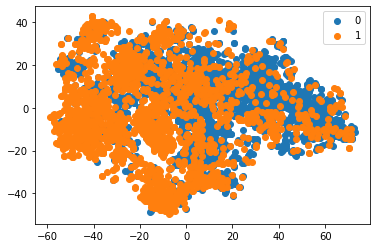

In [ ]:
plot_features(model, 2, 128, 128)

In [ ]:
# Train and Validation function

def train(train_loader, model, criterion, optimizer):
    loss_epoch = 0
    
    for step, (img, lab) in enumerate(train_loader):
        optimizer.zero_grad()
        x_i = img[0]
        x_j = img[1]
        x_i = x_i.to('cuda:0').float()
        x_j = x_j.to('cuda:0').float()

        # positive pair, with encoding
        z_i = model(x_i)
        z_j = model(x_j)
        loss = criterion(z_i, z_j)
        loss.backward()

        optimizer.step()
        
        if nr == 0 and step % 50 == 0:
            print(f"Step [{step}/{len(train_loader)}]\t Loss: {round(loss.item(), 5)}")

        loss_epoch += loss.item()
    return loss_epoch

def valid(valid_loader, model, criterion):
    loss_epoch = 0
    for step, (img, lab) in enumerate(valid_loader):
        x_i = img[0]
        x_j = img[1]
        x_i = x_i.to('cuda:0').float()
        x_j = x_j.to('cuda:0').float()

        # positive pair, with encoding
        z_i = model(x_i)
        z_j = model(x_j)

        loss = criterion(z_i, z_j)
        
        if nr == 0 and step % 50 == 0:
            print(f"Step [{step}/{len(valid_loader)}]\t Loss: {round(loss.item(),5)}")

        loss_epoch += loss.item()
    return loss_epoch

Epoch [0/200]	


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)


Step [0/93]	 Loss: 5.66456
Step [50/93]	 Loss: 5.54977
Adjusting learning rate of group 0 to 4.0000e-02.
Step [0/31]	 Loss: 5.53814
Epoch [0/200]	 Training Loss: 5.589282886956328	 lr: 0.04
Epoch [0/200]	 Validation Loss: 5.536819904081283	 lr: 0.04
Epoch [0/200]	 Time Taken: 0.3488865852355957 minutes
Epoch [1/200]	
Step [0/93]	 Loss: 5.60623
Step [50/93]	 Loss: 5.57444
Adjusting learning rate of group 0 to 6.0000e-02.
Step [0/31]	 Loss: 5.53744
Epoch [1/200]	 Training Loss: 5.5784630877997285	 lr: 0.06
Epoch [1/200]	 Validation Loss: 5.537015653425647	 lr: 0.06
Epoch [1/200]	 Time Taken: 0.34749149878819785 minutes
Epoch [2/200]	
Step [0/93]	 Loss: 5.60014
Step [50/93]	 Loss: 5.53353
Adjusting learning rate of group 0 to 8.0000e-02.
Step [0/31]	 Loss: 5.53766
Epoch [2/200]	 Training Loss: 5.579107387091524	 lr: 0.08
Epoch [2/200]	 Validation Loss: 5.5373585147242395	 lr: 0.08
Epoch [2/200]	 Time Taken: 0.3435107072194417 minutes
Epoch [3/200]	
Step [0/93]	 Loss: 5.53989
Step [50/93]	

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


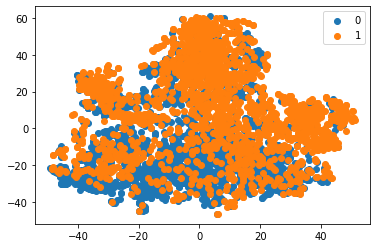

Epoch [10/200]	
Step [0/93]	 Loss: 5.55915
Step [50/93]	 Loss: 5.60022
Epoch     1: adjusting learning rate of group 0 to 2.0000e-01.
Step [0/31]	 Loss: 5.53332
Epoch [10/200]	 Training Loss: 5.56731855228383	 lr: 0.2
Epoch [10/200]	 Validation Loss: 5.535133146470593	 lr: 0.2
Epoch [10/200]	 Time Taken: 0.3469470540682475 minutes
Epoch [11/200]	
Step [0/93]	 Loss: 5.58522
Step [50/93]	 Loss: 5.57916
Epoch     2: adjusting learning rate of group 0 to 1.9999e-01.
Step [0/31]	 Loss: 5.53612
Epoch [11/200]	 Training Loss: 5.56581397210398	 lr: 0.19999
Epoch [11/200]	 Validation Loss: 5.535815884990077	 lr: 0.19999
Epoch [11/200]	 Time Taken: 0.3477304061253866 minutes
Epoch [12/200]	
Step [0/93]	 Loss: 5.52796
Step [50/93]	 Loss: 5.56838
Epoch     3: adjusting learning rate of group 0 to 1.9999e-01.
Step [0/31]	 Loss: 5.53692
Epoch [12/200]	 Training Loss: 5.565535970913467	 lr: 0.19999
Epoch [12/200]	 Validation Loss: 5.536879693308184	 lr: 0.19999
Epoch [12/200]	 Time Taken: 0.339559519

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


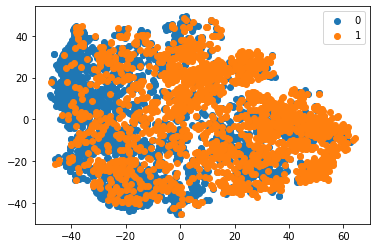

Epoch [20/200]	
Step [0/93]	 Loss: 5.5521
Step [50/93]	 Loss: 5.56022
Epoch    11: adjusting learning rate of group 0 to 1.9982e-01.
Step [0/31]	 Loss: 5.53284
Epoch [20/200]	 Training Loss: 5.56290663442304	 lr: 0.19982
Epoch [20/200]	 Validation Loss: 5.534085350651895	 lr: 0.19982
Epoch [20/200]	 Time Taken: 0.3419228792190552 minutes
Epoch [21/200]	
Step [0/93]	 Loss: 5.58526
Step [50/93]	 Loss: 5.57193
Epoch    12: adjusting learning rate of group 0 to 1.9979e-01.
Step [0/31]	 Loss: 5.53501
Epoch [21/200]	 Training Loss: 5.56141818979735	 lr: 0.19979
Epoch [21/200]	 Validation Loss: 5.535234605112383	 lr: 0.19979
Epoch [21/200]	 Time Taken: 0.3371700684229533 minutes
Epoch [22/200]	
Step [0/93]	 Loss: 5.57051
Step [50/93]	 Loss: 5.59188
Epoch    13: adjusting learning rate of group 0 to 1.9975e-01.
Step [0/31]	 Loss: 5.53634
Epoch [22/200]	 Training Loss: 5.565331069372034	 lr: 0.19975
Epoch [22/200]	 Validation Loss: 5.535677309959166	 lr: 0.19975
Epoch [22/200]	 Time Taken: 0.34

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


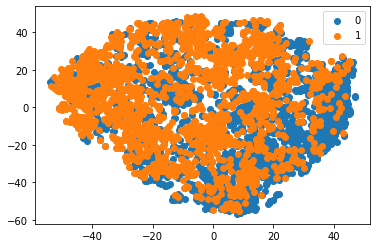

Epoch [30/200]	
Step [0/93]	 Loss: 5.55015
Step [50/93]	 Loss: 5.56177
Epoch    21: adjusting learning rate of group 0 to 1.9935e-01.
Step [0/31]	 Loss: 5.53529
Epoch [30/200]	 Training Loss: 5.560336974359328	 lr: 0.19935
Epoch [30/200]	 Validation Loss: 5.5355460105403775	 lr: 0.19935
Epoch [30/200]	 Time Taken: 0.3838272452354431 minutes
Epoch [31/200]	
Step [0/93]	 Loss: 5.59345
Step [50/93]	 Loss: 5.56778
Epoch    22: adjusting learning rate of group 0 to 1.9928e-01.
Step [0/31]	 Loss: 5.53412
Epoch [31/200]	 Training Loss: 5.561254767961399	 lr: 0.19928
Epoch [31/200]	 Validation Loss: 5.53345977106402	 lr: 0.19928
Epoch [31/200]	 Time Taken: 0.34244139591852824 minutes
Epoch [32/200]	
Step [0/93]	 Loss: 5.5209
Step [50/93]	 Loss: 5.5877
Epoch    23: adjusting learning rate of group 0 to 1.9922e-01.
Step [0/31]	 Loss: 5.53474
Epoch [32/200]	 Training Loss: 5.560144624402446	 lr: 0.19922
Epoch [32/200]	 Validation Loss: 5.533946898675734	 lr: 0.19922
Epoch [32/200]	 Time Taken: 0.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


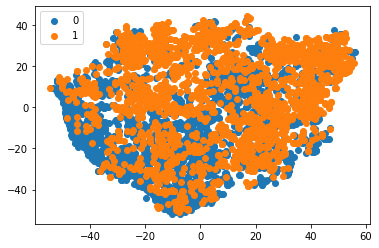

Epoch [40/200]	
Step [0/93]	 Loss: 5.54299
Step [50/93]	 Loss: 5.56872
Epoch    31: adjusting learning rate of group 0 to 1.9858e-01.
Step [0/31]	 Loss: 5.53072
Epoch [40/200]	 Training Loss: 5.563747744406423	 lr: 0.19858
Epoch [40/200]	 Validation Loss: 5.5305709685048745	 lr: 0.19858
Epoch [40/200]	 Time Taken: 0.3476591229438782 minutes
Epoch [41/200]	
Step [0/93]	 Loss: 5.5177
Step [50/93]	 Loss: 5.56682
Epoch    32: adjusting learning rate of group 0 to 1.9849e-01.
Step [0/31]	 Loss: 5.53371
Epoch [41/200]	 Training Loss: 5.56126763743739	 lr: 0.19849
Epoch [41/200]	 Validation Loss: 5.532435986303514	 lr: 0.19849
Epoch [41/200]	 Time Taken: 0.34630000988642373 minutes
Epoch [42/200]	
Step [0/93]	 Loss: 5.53065
Step [50/93]	 Loss: 5.54084
Epoch    33: adjusting learning rate of group 0 to 1.9839e-01.
Step [0/31]	 Loss: 5.53005
Epoch [42/200]	 Training Loss: 5.565476545723536	 lr: 0.19839
Epoch [42/200]	 Validation Loss: 5.530158719708843	 lr: 0.19839
Epoch [42/200]	 Time Taken: 0

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


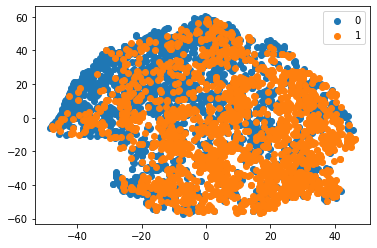

Epoch [50/200]	
Step [0/93]	 Loss: 5.55882
Step [50/93]	 Loss: 5.56776
Epoch    41: adjusting learning rate of group 0 to 1.9753e-01.
Step [0/31]	 Loss: 5.53252
Epoch [50/200]	 Training Loss: 5.56317538087086	 lr: 0.19753
Epoch [50/200]	 Validation Loss: 5.531639514430877	 lr: 0.19753
Epoch [50/200]	 Time Taken: 0.34650592803955077 minutes
Epoch [51/200]	
Step [0/93]	 Loss: 5.59116
Step [50/93]	 Loss: 5.57775
Epoch    42: adjusting learning rate of group 0 to 1.9740e-01.
Step [0/31]	 Loss: 5.53285
Epoch [51/200]	 Training Loss: 5.563165464708882	 lr: 0.1974
Epoch [51/200]	 Validation Loss: 5.5311434961134385	 lr: 0.1974
Epoch [51/200]	 Time Taken: 0.34322159687678017 minutes
Epoch [52/200]	
Step [0/93]	 Loss: 5.55171
Step [50/93]	 Loss: 5.56273
Epoch    43: adjusting learning rate of group 0 to 1.9728e-01.
Step [0/31]	 Loss: 5.53181
Epoch [52/200]	 Training Loss: 5.560333159662062	 lr: 0.19728
Epoch [52/200]	 Validation Loss: 5.530346824276831	 lr: 0.19728
Epoch [52/200]	 Time Taken: 0

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


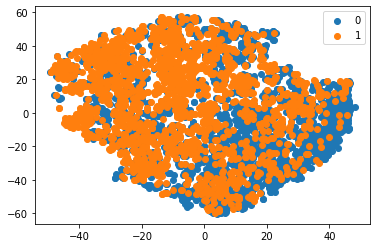

Epoch [60/200]	
Step [0/93]	 Loss: 5.53954
Step [50/93]	 Loss: 5.5548
Epoch    51: adjusting learning rate of group 0 to 1.9618e-01.
Step [0/31]	 Loss: 5.5322
Epoch [60/200]	 Training Loss: 5.564525091519919	 lr: 0.19618
Epoch [60/200]	 Validation Loss: 5.531056742514333	 lr: 0.19618
Epoch [60/200]	 Time Taken: 0.34669819672902424 minutes
Epoch [61/200]	
Step [0/93]	 Loss: 5.5543
Step [50/93]	 Loss: 5.5673
Epoch    52: adjusting learning rate of group 0 to 1.9603e-01.
Step [0/31]	 Loss: 5.53043
Epoch [61/200]	 Training Loss: 5.561746556271789	 lr: 0.19603
Epoch [61/200]	 Validation Loss: 5.529511467103036	 lr: 0.19603
Epoch [61/200]	 Time Taken: 0.3407232443491618 minutes
Epoch [62/200]	
Step [0/93]	 Loss: 5.58514
Step [50/93]	 Loss: 5.55633
Epoch    53: adjusting learning rate of group 0 to 1.9588e-01.
Step [0/31]	 Loss: 5.52795
Epoch [62/200]	 Training Loss: 5.559258660962505	 lr: 0.19588
Epoch [62/200]	 Validation Loss: 5.526995474292386	 lr: 0.19588
Epoch [62/200]	 Time Taken: 0.34

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


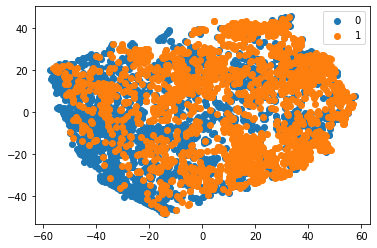

Epoch [70/200]	
Step [0/93]	 Loss: 5.56417
Step [50/93]	 Loss: 5.55385
Epoch    61: adjusting learning rate of group 0 to 1.9456e-01.
Step [0/31]	 Loss: 5.52869
Epoch [70/200]	 Training Loss: 5.564090985123829	 lr: 0.19456
Epoch [70/200]	 Validation Loss: 5.527236030947778	 lr: 0.19456
Epoch [70/200]	 Time Taken: 0.3450407822926839 minutes
Epoch [71/200]	
Step [0/93]	 Loss: 5.57471
Step [50/93]	 Loss: 5.54448
Epoch    62: adjusting learning rate of group 0 to 1.9438e-01.
Step [0/31]	 Loss: 5.52808
Epoch [71/200]	 Training Loss: 5.561071149764523	 lr: 0.19438
Epoch [71/200]	 Validation Loss: 5.528751019508608	 lr: 0.19438
Epoch [71/200]	 Time Taken: 0.3357693870862325 minutes
Epoch [72/200]	
Step [0/93]	 Loss: 5.54948
Step [50/93]	 Loss: 5.56821
Epoch    63: adjusting learning rate of group 0 to 1.9420e-01.
Step [0/31]	 Loss: 5.5242
Epoch [72/200]	 Training Loss: 5.557789161641111	 lr: 0.1942
Epoch [72/200]	 Validation Loss: 5.530050400764711	 lr: 0.1942
Epoch [72/200]	 Time Taken: 0.40

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


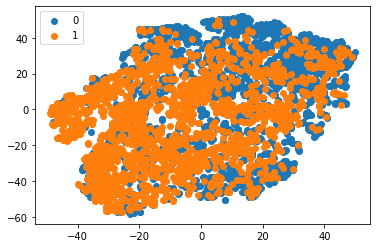

Epoch [80/200]	
Step [0/93]	 Loss: 5.56828
Step [50/93]	 Loss: 5.55057
Epoch    71: adjusting learning rate of group 0 to 1.9266e-01.
Step [0/31]	 Loss: 5.5134
Epoch [80/200]	 Training Loss: 5.556122179954283	 lr: 0.19266
Epoch [80/200]	 Validation Loss: 5.5198936000947025	 lr: 0.19266
Epoch [80/200]	 Time Taken: 0.34500492811203004 minutes
Epoch [81/200]	
Step [0/93]	 Loss: 5.59503
Step [50/93]	 Loss: 5.52897
Epoch    72: adjusting learning rate of group 0 to 1.9246e-01.
Step [0/31]	 Loss: 5.5184
Epoch [81/200]	 Training Loss: 5.557193335666452	 lr: 0.19246
Epoch [81/200]	 Validation Loss: 5.519079362192461	 lr: 0.19246
Epoch [81/200]	 Time Taken: 0.34094937245051066 minutes
Epoch [82/200]	
Step [0/93]	 Loss: 5.5922
Step [50/93]	 Loss: 5.5673
Epoch    73: adjusting learning rate of group 0 to 1.9225e-01.
Step [0/31]	 Loss: 5.52123
Epoch [82/200]	 Training Loss: 5.562141515875376	 lr: 0.19225
Epoch [82/200]	 Validation Loss: 5.519017850199053	 lr: 0.19225
Epoch [82/200]	 Time Taken: 0.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


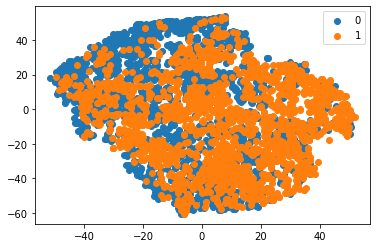

Epoch [90/200]	
Step [0/93]	 Loss: 5.55677
Step [50/93]	 Loss: 5.541
Epoch    81: adjusting learning rate of group 0 to 1.9049e-01.
Step [0/31]	 Loss: 5.49052
Epoch [90/200]	 Training Loss: 5.558690614597772	 lr: 0.19049
Epoch [90/200]	 Validation Loss: 5.503458115362352	 lr: 0.19049
Epoch [90/200]	 Time Taken: 0.34008886814117434 minutes
Epoch [91/200]	
Step [0/93]	 Loss: 5.54808
Step [50/93]	 Loss: 5.5736
Epoch    82: adjusting learning rate of group 0 to 1.9026e-01.
Step [0/31]	 Loss: 5.50022
Epoch [91/200]	 Training Loss: 5.558135637672999	 lr: 0.19026
Epoch [91/200]	 Validation Loss: 5.505494840683475	 lr: 0.19026
Epoch [91/200]	 Time Taken: 0.336096453666687 minutes
Epoch [92/200]	
Step [0/93]	 Loss: 5.55813
Step [50/93]	 Loss: 5.55298
Epoch    83: adjusting learning rate of group 0 to 1.9003e-01.
Step [0/31]	 Loss: 5.49859
Epoch [92/200]	 Training Loss: 5.561414205899802	 lr: 0.19003
Epoch [92/200]	 Validation Loss: 5.5061291879223235	 lr: 0.19003
Epoch [92/200]	 Time Taken: 0.3

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


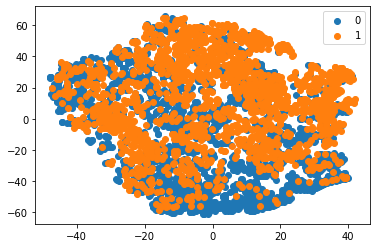

In [ ]:
# Train loop

tr_loss = []
val_loss = []

nr = 0
global_step = 0
current_epoch = 0

for epoch in range(100):
        
    print(f"Epoch [{epoch}/{epochs}]\t")
    stime = time.time()

    model.train()
    tr_loss_epoch = train(dataloader_img, model, criterion, optimizer)

    if nr == 0 and epoch < 10:
        warmupscheduler.step()
    if nr == 0 and epoch >= 10:
        mainscheduler.step()
    
    lr = optimizer.param_groups[0]["lr"]

    model.eval()
    with torch.no_grad():
        val_loss_epoch = valid(dataloader_img_v, model, criterion)

    if nr == 0:
        
        tr_loss.append(tr_loss_epoch / len(dataloader_img))
        
        val_loss.append(val_loss_epoch / len(dataloader_img_v))
        
        print(
            f"Epoch [{epoch}/{epochs}]\t Training Loss: {tr_loss_epoch / len(dataloader_img)}\t lr: {round(lr, 5)}"
        )
        print(
            f"Epoch [{epoch}/{epochs}]\t Validation Loss: {val_loss_epoch / len(dataloader_img_v)}\t lr: {round(lr, 5)}"
        )
        current_epoch += 1

    time_taken = (time.time()-stime)/60
    print(f"Epoch [{epoch}/{epochs}]\t Time Taken: {time_taken} minutes")

    if (epoch+1)%10==0:
        plot_features(model, 2, 128, 128)

# TASK

### First step: data preparation


In [ ]:
def dataPrep(dataloader):
  X = torch.Tensor(np.zeros(1))
  Y = torch.Tensor(np.zeros(1))
  t=0
  for step, (img, lab) in enumerate(dataloader):
        x_i = img[0]
        x_j = img[1]
        x_i = x_i.to('cuda:0').float()
        x_j = x_j.to('cuda:0').float()
        #base è la prima parte del modello, restituisce h:
        z_i = base(x_i)
        z_j = base(x_j)
        if t==0:
          X=z_i
          Y=lab
          X=torch.cat((X,z_j), 0)
          Y=torch.cat((Y,lab))
        else :
          X=torch.cat((X,z_i), 0)
          Y=torch.cat((Y,lab))
          X=torch.cat((X,z_j), 0)
          Y=torch.cat((Y,lab))
        t+=1
  return X, Y

Xt, Yt =dataPrep(dataloader_img)
Xv, Yv =dataPrep(dataloader_img_v)
print("prima del rimaneggiamento:", Xt.shape)
#Xt = torch.unsqueeze(Xt, dim=0)
#Xt = Xt.permute(1,0,2)
#Xv = torch.unsqueeze(Xv, dim=0)
#Xv = Xv.permute(1,0,2)
print("final Xt shape:", Xt.shape)
print("final Xv shape:", Xv.shape)
print("Yt shape:",Yt.shape)
print("Yv shape:",Yv.shape)
#nota: otteniamo 23808 dati, ovvero: trunc(12000/128)*128*2


prima del rimaneggiamento: torch.Size([23808, 64])
final Xt shape: torch.Size([23808, 64])
final Xv shape: torch.Size([7936, 64])
Yt shape: torch.Size([23808])
Yv shape: torch.Size([7936])


In [ ]:
dataset_trainR = TensorDataset(Xt, Yt) 
dataloader_trainR = DataLoader(dataset_trainR, batch_size=64, shuffle=True)
dataset_validationR_ = TensorDataset(Xv, Yv) 
dataloader_validationR = DataLoader(dataset_validationR_, batch_size=64, shuffle=True)
#images, label = dataset_img[i]


In [ ]:
class LogisticRegression(nn.Module):
  def __init__(self):
    super(LogisticRegression, self).__init__()
    self.linear=torch.nn.Linear(64, 1)

  def forward(self,x):
    output = torch.sigmoid(self.linear(x))
    return output


In [ ]:
modelReg = LogisticRegression()
print(modelReg)

from torchsummary import summary
if torch.cuda.is_available():
  summary(modelReg.cuda(), input_size=(1,64))
else:
  summary(modelReg, input_size=(1,64))

LogisticRegression(
  (linear): Linear(in_features=64, out_features=1, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 1]              65
Total params: 65
Trainable params: 65
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [ ]:
#train loop for LogicRegression

import time

save_best_modelR = SaveBestModel()

# lists to save loss and metric history
hist_lossR = []
hist_metricR = []
hist_vlossR = []
hist_vmetricR = []

#loop over epochs
for epoch in range(epochs):
    t0 = time.time()

    #training step
    modelReg.train()

    train_loss = 0.0
    train_metric = 0.0
    counter = 0
    for xb, yb in dataloader_trainR: #takes a batch from the train dataloader 
        counter += 1 
        xb=xb.type(torch.float).to(device) #move torch tensors to device (cpu or GPU)
        yb=yb.type(torch.float).to(device)
        
        pred = modelReg(xb) #get prediction for batch
        loss = loss_func(pred, torch.unsqueeze(yb,1)) #compute loss
        metric = metric_func(pred, yb) #compute metric

        train_loss += loss.item() #update total loss
        train_metric += metric.item() #update total metric

        # backpropagation
        loss.backward(retain_graph=True)
        # update weights
        opt.step()
        # set to zero gradients for the next step
        opt.zero_grad()

        
    # normalize loss and metric by number of batches
    train_loss = train_loss/counter
    train_metric = train_metric/counter

    # update history
    hist_lossR.append(train_loss)
    hist_metricR.append(train_metric)


    # evaluation setp (same as trainign but w/o backpropagation)
    model.eval()

    vali_loss = 0.0
    vali_metric = 0.0
    counter = 0
    with torch.no_grad():
      for xb, yb in dataloader_validationR:
        counter += 1
        xb=xb.type(torch.float).to(device)
        yb=yb.type(torch.float).to(device)
        pred = modelReg(xb)
        vloss = loss_func(pred, torch.unsqueeze(yb,1))
        vmetric = metric_func(pred, yb)
        vali_loss += vloss.item()
        vali_metric += vmetric.item()
        
    vali_loss = vali_loss/counter
    vali_metric = vali_metric/counter    

    hist_vlossR.append(vali_loss)
    hist_vmetricR.append(vali_metric)

    #save best model
    save_best_model(vali_loss, epoch, model, opt, loss_func, metric_func)   

    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.4f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f" % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric))

    # update learning rate schedule
    #scheduler.step()

RuntimeError: ignored

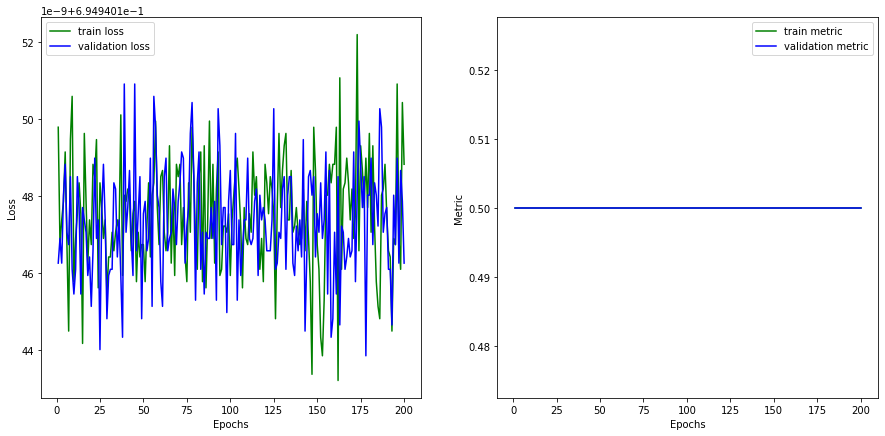

In [ ]:
#plot results

plt.figure(figsize=(15, 7))
plt.subplot(1,2,1)
plt.plot(range(1,len(hist_lossR)+1), hist_lossR, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_vlossR)+1), hist_vlossR, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1,len(hist_metricR)+1), hist_metricR,  color='green', linestyle='-', label='train metric')
plt.plot(range(1,len(hist_vmetricR)+1),hist_vmetricR, color='blue', linestyle='-', label='validation metric')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()

## To do##


1.   play with the code, understand it, play with hyperparameters (mini-batch size). It is not optmized for the specific task.
2.   save the trained model and test it by evaluating the quality of the representations learned using a linear evaluation protocol: a logistic regression model:


```
- take the training data and pass it through the pre-trained SimCLR model and store the output representations from the f() model (CNN)
- use these fixed representations to train a Logistic Regression model using the training labels as targets
- the testing accuracy is a measure of the feature quality
- compare with the feature extracted from the first model trained with a supervised protocol

NOTE: since the base network 𝑓(⋅) is not changed during the training process of the
logistic regression, the model can only perform well if the representations of h describe all features that might be necessary for the task
```

